In [1]:
import numpy as np
import matplotlib.pyplot as plt
line = lambda v: np.linspace(v.min(),v.max(),11)
from SimpleLammps import SimpleLammps, NiMo_potential_data

Under some perturbation $\delta{\bf X}\in\mathbb{R}^{3N}$ from ${\bf X}_0$ the forces change as:
$$
    {\bf F}({\bf X}_0+\delta{\bf X}) = {\bf F}_0 + {\bf H}_0\delta{\bf X} + \mathcal{O}(\|\delta{\bf X}\|^2),
$$
where ${\bf F}_0$ and ${\bf H}_0$ are the reference forces and Hessian. In our applications, ${\bf F}_0={\bf 0}$.

Rather than calculate and store ${\bf H}_0$ explicitly we can replace ${\bf H}_0\delta{\bf X}$ by the linear operator
$\mathcal{L}:\mathbb{R}^{3N}\to\mathbb{R}^{3N}$:
$$
    \mathcal{L}_\alpha(\delta{\bf X}) \equiv \left({\bf F}({\bf X}+\alpha\delta{\bf X}) - {\bf F}_0\right)/\alpha,
    \quad
    \Rightarrow
    \lim_{\alpha\to0} \mathcal{L}_\alpha(\delta{\bf X}) = {\bf H}_0\delta{\bf X}.
$$
which can be used, via `scipy.sparse.linalg.LinearOperator`, in numerical solution schemes such as `lgmres` or similar

Providing displacements are small this should work....


We manually prescribe the coefficients a binary SNAP potential for NiMo- https://doi.org/10.1103/PhysRevB.98.094104

In [13]:

strength = 0.03

new_potential_data = NiMo_potential_data.copy()
p_dT = np.zeros_like(new_potential_data['A']['theta'])

new_potential_data['A']['theta'] += p_dT
new_potential_data['B']['theta'] += p_dT

S = SimpleLammps(potential = new_potential_data,
    start_script="""
    region C block 0 2 0 2 0 3 units lattice
    create_box 2 C
    create_atoms 1 region C
    set group all type/fraction 2 0.5 12393
    #group del id 10
    #delete_atoms group del
""")

print("MINIMIZED")

dDdV = S.get_dilation_dD()
T = S.Theta
dT = strength * np.random.uniform(-1.,1.,size=(T.size))*T.flatten()
# ensure perturbation does not change dE/dV slope
P = np.outer(dDdV,dDdV)/(dDdV@dDdV)
dT -= P@dT

MINIMIZED


In [12]:

pred_dE,pred_dX = S.perturb(dT,method="Hessian")

E0 = S.get_E(np.zeros_like(pred_dX),np.zeros_like(dT))

pred_alt_dE = S.get_E(pred_dX,dT) - E0


first_order_dE = S.g@dT

new_potential_data = NiMo_potential_data.copy()
new_potential_data['file_name']='potentials/temp'
new_potential_data['A']['theta'] += dT.reshape((2,-1))[0]
new_potential_data['B']['theta'] += dT.reshape((2,-1))[1]

true_dE,true_dX = S.exact_perturb(dT,new_potential_data)
true_alt_dE = S.get_E(true_dX,dT) - E0


print(f"""
    dE (all orders):
        True  : {np.round(true_dE,4)} ( E(X+dX) - E(X) )
        Taylor: {np.round(pred_dE,4)} ( f.dT - dT.Cg.dT/2 )
        Mixed : {np.round(pred_alt_dE,4)} ( E(X+g.dT) - E(X) )
    """)
true_dE -= first_order_dE
pred_dE -= first_order_dE
pred_alt_dE -= first_order_dE
print(f"""   
    dE - f.dT (removed first order change)
        True: {np.round(true_dE,4)}
        Taylor: {np.round(pred_dE,4)} ({np.round(100.*pred_dE/true_dE-100.,2)}%)
        Mixed: {np.round(pred_alt_dE,4)} ({np.round(100.*pred_alt_dE/true_dE-100.,2)}%)
        
    
    dX MAE = {np.round(np.abs(true_dX.flatten()-pred_dX.flatten()).mean(),4)}
""")


    dE (all orders):
        True  : 0.9353 ( E(X+dX) - E(X) )
        Taylor: 0.9305 ( f.dT - dT.Cg.dT/2 )
        Mixed : 0.9306 ( E(X+g.dT) - E(X) )
    
   
    dE - f.dT (removed first order change)
        True: -0.0006
        Taylor: -0.0054 (786.69%)
        Mixed: -0.0053 (776.79%)
        
    
    dX MAE = 0.0057



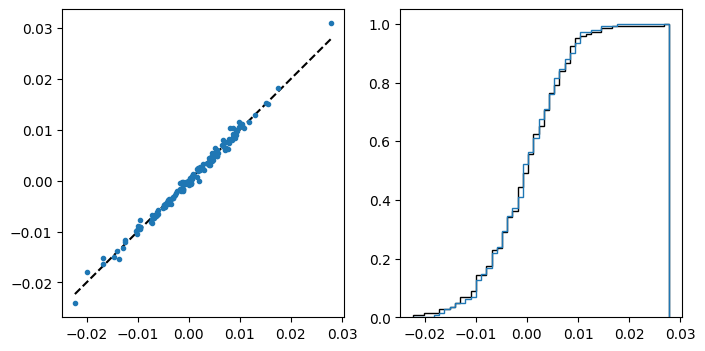

In [4]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(line(true_dX.flatten()),line(true_dX.flatten()),'k--')
axs[0].plot(true_dX.flatten(),pred_dX.flatten(),'.')
b = np.linspace(min(true_dX),max(true_dX))
axs[1].hist(true_dX.flatten(),bins=b,
                            density=True,cumulative=True,
                            color='k',histtype='step')
axs[1].hist(pred_dX.flatten(),bins=b,
                            density=True,cumulative=True,
                            color='C0',histtype='step')
plt.show()


In [44]:
S = SimpleLammps(potential = new_potential_data,
    start_script="""
    region C block 0 2 0 2 0 2 units lattice
    create_box 2 C
    create_atoms 1 region C
    set group all type/fraction 2 0.5 12393
""")
S.L.scatter("x",1,3,np.ctypeslib.as_ctypes(S.x))
S.L.commands_string("""
    fix cv all property/atom d_cx d_cy d_cz
    compute d all displace/atom
""")


100%|██████████| 96/96 [00:00<00:00, 192.29it/s]


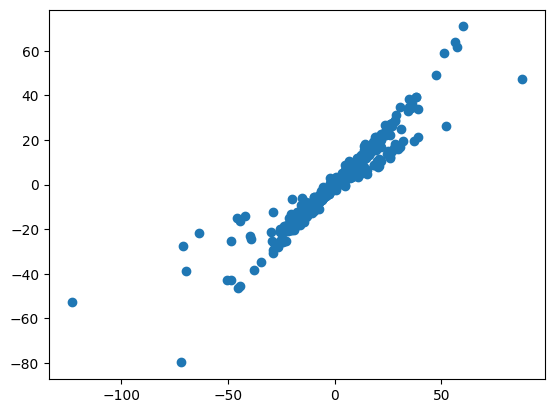

In [103]:
from tqdm import tqdm

S = SimpleLammps(potential = new_potential_data,
    start_script="""
    region C block 0 2 0 2 0 2 units lattice
    create_box 2 C
    create_atoms 1 region C
    set group all type/fraction 2 0.5 12393
    min_style fire
    mass * 184
    minimize 0 1e-10 1000 1000
""")

S.L.scatter("x",1,3,np.ctypeslib.as_ctypes(S.x))
S.L.commands_string("""
    fix cv all property/atom d_cx d_cy d_cz
    compute d all displace/atom
""")
dX_E = []
alpha = 0.0005
for c in tqdm(S.C.T):
    S.L.scatter("x",1,3,np.ctypeslib.as_ctypes(S.x))
    for i,c_v in enumerate(["d_cx","d_cy","d_cz"]):
        v = c.reshape((-1,3))[:,i].astype(np.float64)*alpha
        S.L.scatter(c_v,1,1,np.ctypeslib.as_ctypes(v))

    S.L.commands_string("""
        compute c all property/atom d_cx d_cy d_cz
        variable fx atom c_c[1]
        variable fy atom c_c[2]
        variable fz atom c_c[3]
        variable e atom v_fx*c_d[1]+v_fy*c_d[2]+v_fz*c_d[3]
        fix f all addforce v_fx v_fy v_fz energy v_e
        run 0
        minimize 0. 1e-10 100 100
    """)
    dX_E += [(np.ctypeslib.as_array(S.L.gather("x",1,3)).flatten() - S.x)/alpha]
    S.L.commands_string("""
        uncompute c 
        unfix f
    """)
S.L.commands_string("""
            variable fx delete
            variable fy delete
            variable fz delete
        """)
dX_E = np.array(dX_E) 
dX_H = S.implicit_derivative(method="Hessian")
plt.scatter(dX_E.flatten(),dX_H.flatten())


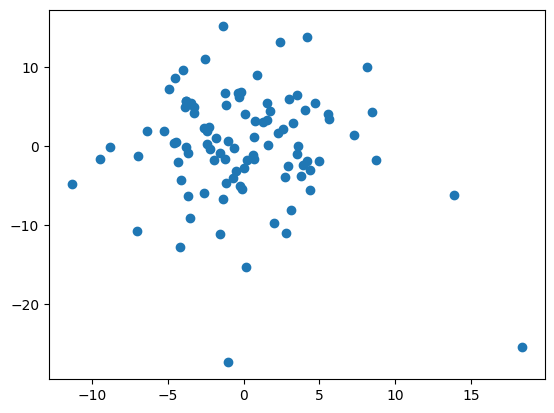

In [102]:
plt.scatter(dX_E[0],dX_H[0])

In [ ]:
        elif method=="EnergyFix":

            self.L.scatter("x",1,3,np.ctypeslib.as_ctypes(self.x))
            
            self.L.commands_string("""
                fix cv all property/atom d_cx d_cy d_cz
                compute d all displace/atom
            """)

            for c in tqdm(self.C.T):
                for i,c in enumerate(["d_cx","d_cy","d_cz"]):
                    self.L.scatter(c,c.reshape((-1,3))[:,i])
                
                self.L.commands_string("""
                    variable e atom d_cx*c_d[1]+d_cy*c_d[2]+d_cz*c_d[3]
                    compute f all addforce d_cx[*] d_cy[*] d_cz[*] energy v_e
                """)


In [ ]:

            

            res = self.implicit_derivative(return_values=False)
            print("Total force calls:",res['calls'],sum(res['calls']))
            elif method=="EnergyFix":
                res = self.i
                self.L.commands_string



        dX0 = np.zeros_like(self.x) # initial displacements
        F0 = self.compute_forces(dX0,alpha) # reinitialize LAMMPS

        # define linear operator with matrix-vector product mv()
        def mv(dx):
            alpha = 0.005/max(np.abs(dx).max(),1.0)
            return (F0-self.compute_forces(dx,alpha))/alpha
        L = LinearOperator((self.N,self.N),matvec=mv,rmatvec=mv)
        
        

        # result holder
        res = {'dX':[],'err':[],'calls':[]}
        
        # One linear solutions per parameter
        for c in tqdm(self.C.T):
            
            # perform iterative linear solution routine
            ss = self.step
            dX = bicg(L,c,x0=np.zeros_like(c))[0]
            
            # log results
            res['dX'] += [dX]
            res['err'] += [np.linalg.norm(mv(dX)-c)]
            res['calls'] += [self.step-ss]
        
        # convert to dictionary of numpy arrays
        res = {k: np.array(res[k]) for k in res}

        # store internally
        self.dX = res['dX'].copy()

        # return values
        return res